In [5]:
%matplotlib inline
import time
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [6]:
class Grid():
    def __init__(self, n, m, n_home, m_home, delta, T, F):
        self.pheremones = np.zeros((n,m),dtype=float)
        self.food = np.zeros((n,m),dtype=float)
        self.occupancy = np.zeros((n,m), dtype=float)
        self.delta = delta
        self.home = (n_home, m_home)
        self.food_drop = 0
        
#         self.food[55:65, 55:65] = 1  # For testing 
        self.place_food(T, F)
    
    def evaporate(self):
        self.pheremones -= self.delta*self.pheremones
    
    def place_food(self, T, F):
        n_food = int(T / F)
        side = int(F**0.5)
        placed = 0
        while placed < n_food:
            ctr = np.random.randint((1,2), 100)
            if ctr[0]-side >= 0 and ctr[0]+side < 100 and ctr[1]-side >= 0 and ctr[1]+side < 100:
#                 print(ctr)
                if np.sum(self.food[ctr[0]-side:ctr[0]+side, ctr[1]-side:ctr[1]+side]) == 0:
                    self.food[ctr[0]-side:ctr[0]+side, ctr[1]-side:ctr[1]+side] = 1
                    placed += 1
                
        
        

In [7]:
class Ant():
    def __init__(self, n, m, n_home, m_home, q, sigma_1, sigma_2, mu, grid):
        self.loc = (n, m)
        self.home = (n_home, m_home)
        
        self.q = q
        self.sigma_1 = sigma_1
        self.sigma_2 = sigma_2
        self.mu = mu
        
#         self.dir = self.randomize_dir(grid)
        self.dir = (1, 0)
        
        self.hasfood = False
        self.removed = False
    
    def randomize_dir(self, grid):
        p0 = grid.pheremones[self.loc[0], self.loc[1]+1] + grid.pheremones[self.loc[0]+1, self.loc[1]+1] + grid.pheremones[self.loc[0]-1, self.loc[1]+1]
        p1 = grid.pheremones[self.loc[0]+1, self.loc[1]] + grid.pheremones[self.loc[0]+1, self.loc[1]+1] + grid.pheremones[self.loc[0]+1, self.loc[1]-1]
        p2 = grid.pheremones[self.loc[0], self.loc[1]-1] + grid.pheremones[self.loc[0]+1, self.loc[1]-1] + grid.pheremones[self.loc[0]-1, self.loc[1]-1]
        p3 = grid.pheremones[self.loc[0]-1, self.loc[1]] + grid.pheremones[self.loc[0]-1, self.loc[1]+1] + grid.pheremones[self.loc[0]-1, self.loc[1]-1]
        
        ps = p0 + p1 + p2 + p3
        if ps != 0:
            p0 /= ps
            p1 /= ps
            p2 /= ps
            p3 /= ps
        
            did = np.random.choice([0,1,2,3], 1, p=[p0,p1,p2,p3])
        else:
            did = np.random.choice(4, 1)
        if did == 0:
            direction = (0, 1)
        elif did == 1:
            direction = (1, 0)
        elif did == 2:
            direction = (0, -1)
        elif did == 3:
            direction = (-1, 0)
        return direction
    
    def move(self, grid):
        if self.loc[0] == 0 or self.loc[1] == 0 or self.loc[0] == grid.occupancy.shape[0]-1 or self.loc[1] == grid.occupancy.shape[1]-1:
            self.removed = True
#             print("Boarder!")
        if not self.removed:
            left_loc = (self.loc[0]+self.dir[1]+self.dir[0], self.loc[1]-self.dir[0]+self.dir[1])
            front_loc = (self.loc[0]+self.dir[0], self.loc[1]+self.dir[1])
            right_loc = (self.loc[0]-self.dir[1]+self.dir[0], self.loc[1]+self.dir[0]+self.dir[1])
        
            lp = grid.pheremones[left_loc[0], left_loc[1]]
            fp = grid.pheremones[front_loc[0], front_loc[1]]
            rp = grid.pheremones[right_loc[0], right_loc[1]]
            
            p_m = 0.5 * (1 + np.tanh((lp + fp + rp)/100 - 1))
            if np.random.choice(2, 1, p=[1-p_m,p_m]):
                c = (self.mu + lp)**2 + (self.mu + fp)**2 + (self.mu + rp)**2
                p_left = 1/c * (self.mu + lp)**2
                p_front = 1/c * (self.mu + fp)**2
                p_right = 1/c * (self.mu + rp)**2
                
                next_loc = np.random.choice(["left_loc","right_loc","front_loc"], 1, p=[p_left,p_right,p_front])
                if next_loc == "left_loc" and grid.occupancy[left_loc[0], left_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = left_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1
                elif next_loc == "front_loc" and grid.occupancy[front_loc[0], front_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = front_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1
                elif next_loc == "right_loc" and grid.occupancy[right_loc[0], right_loc[1]] < Am:
                    grid.occupancy[self.loc[0], self.loc[1]] -= 1
                    self.loc = right_loc
                    grid.occupancy[self.loc[0], self.loc[1]] += 1

                    
                if grid.food[self.loc[0], self.loc[1]] > 0:
                    if not self.hasfood:
                        g.food[self.loc[0], self.loc[1]] -= 1
                        self.dir = (self.dir[0]*-1, self.dir[1]*-1) # Flips direction
                        self.hasfood = True
                        
                        
                if (self.home[0]-1 < self.loc[0] < self.home[0]+1) and (self.home[1]-1 < self.loc[1] < self.home[1]+1) and self.hasfood:
                    self.hasfood = False
                    grid.occupancy[self.home[0], self.home[1]] -= 1
                    grid.food_drop += 1
                    self.removed = True
#                     print("Brought back food!")
                    
                    
            if self.hasfood:
                if grid.pheremones[self.loc[0], self.loc[1]] < self.sigma_2:
                    grid.pheremones[self.loc[0],self.loc[1]] += self.q
            else:
                if grid.pheremones[self.loc[0], self.loc[1]] < self.sigma_1:
                    grid.pheremones[self.loc[0], self.loc[1]] += 1.
    
    def plot(self):
        if self.hasfood:
            color = 'red'
        else:
            color = 'green'
        plt.scatter(self.loc[0], self.loc[1], color=color)
        

In [11]:
def simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations=100):
    fitness = 0
    fig, _ = plt.subplots(figsize=(10, 20))
    
    for _ in range(iterations):
        for _ in range(Nb):
            if g.occupancy[g.home[0], g.home[1]] < Am:
                ants.append(Ant(g.home[0], g.home[1], g.home[0], g.home[1], q, sigma_1, sigma_2, mu, g))
                g.occupancy[g.home[0], g.home[1]] += 1
                
        for ant in ants:
            ant.move(g)
            if ant.removed:
                ants.remove(ant)
                continue

        g.evaporate()
        
        fitness += (g.food_drop / np.sum(g.occupancy))
        g.food_drop = 0
        
        # Plot
        plt.imshow(g.pheremones.T)
#         plt.imshow(g.food.T)
        plt.scatter(g.home[0], g.home[1], color='blue')
#         for y in range(g.food.shape[0]):
#             for x in range(g.food.shape[1]):
#                 if g.food[y,x] == 1:
#                     plt.scatter(y, x, color='yellow')
#         for ant in ants:
#             ant.plot()
        
        # Animaiton part
        clear_output(wait=True) # Clear output for dynamic display
        display(fig)            # Reset display
        fig.clear()             # Prevent overlapping and layered plots
        time.sleep(0.0001)      # Sleep to allow animation to catch up
    
    return fitness

In [12]:
def optimize_parameters(mins, maxs, m, n, T, F, Am, Nb, tau, e, param_collection, iterations=500):
    avg_fitness = 0
    indiv_fitness = list()
    
    for i in range(N):
        if len(param_collection) != N:
            rands = np.random.rand(5)
            params = rands * maxs + (1-rands) * mins
            param_collection.append(params)
        else:
            params = param_collection[i]
        
        print("Params:", params)
        q = params[0]
        sigma_1 = params[1]
        sigma_2 = params[2]
        mu = params[3]
        delta = params[4]
        
        g = Grid(100, 100, m, n, delta, T, F)
        ants = list()
        tic = time.perf_counter()
        f = simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations)
        toc = time.perf_counter()
        print("Fitness of N {}:".format(i), f)
        print(f"Time to simulate 1 N in {toc - tic:0.4f} seconds")
        indiv_fitness.append(f)
        avg_fitness += f

    avg_fitness /= N
    print("Generation fitness:", avg_fitness)

    for i in range(N):
        if indiv_fitness[i] < avg_fitness:
            param_collection.pop(i)
            gen_new = np.random.choice([0,1], 1, p=[1-tau,tau])
            if gen_new:
                rands = np.random.rand(5)
                params = rands * maxs + (1-rands) * mins
                param_collection.insert(i, params)
            else:
                param_id = np.random.choice(len(param_collection))
                params = param_collection[param_id]
                plus_minus_e = np.random.choice(2)
                if plus_minus_e:
                    params = params*(1+e)
                else:
                    params = params*(1-e)
                params = np.maximum(mins, params)
                params = np.minimum(maxs, params)
                param_collection.insert(i, params)
    
    return param_collection

In [ ]:
q_min = 1
sigma_min = 0.0001
mu_min = 0.0001
delta_min = 0.001

q_max = 50
sigma_max = 1000
mu_max = 50
delta_max = 1

Am = 30
Nb = 10

m = 3
n = 50

T = 200
F = 4

G = 30
N = 8

mins = np.array([q_min, sigma_min, sigma_min, mu_min, delta_min])
maxs = np.array([q_max, sigma_max, sigma_max, mu_max, delta_max])

tau = 0.5
e = 0.2

param_collection = list()

for i in range(G):
    print("Generation", i)
    param_collection = optimize_parameters(mins, maxs, m, n, T, F, Am, Nb, tau, e, param_collection, iterations=1000)
    print(param_collection)

Generation 0
Params: [ 21.81686216 154.37377204 746.72741411  15.30072432   0.7619274 ]
Fitness of N 0: 0.009756551147010307
Time to simulate 1 N in 103.8738 seconds
Params: [ 44.315124   525.44656419 246.35777386   4.59529359   0.70482271]
Fitness of N 1: 0.010382929536057317
Time to simulate 1 N in 104.3795 seconds
Params: [ 42.31315631 710.90249485 296.50854603  46.57971659   0.85475338]
Fitness of N 2: 0.041826592944495866
Time to simulate 1 N in 87.7111 seconds
Params: [3.17882926e+00 6.31037614e+02 4.22732161e+02 4.24060276e+01
 1.32755197e-01]
Fitness of N 3: 0.09682664434827613
Time to simulate 1 N in 94.5341 seconds
Params: [4.99457539e+01 6.37674475e+02 4.39454857e+02 3.82822135e+01
 5.75273004e-01]
Fitness of N 4: 0.003903313311061047
Time to simulate 1 N in 135.0087 seconds
Params: [2.55519034e+01 6.14745946e+02 1.31200172e+01 4.04203267e+01
 4.78947579e-01]
Fitness of N 5: 0.4173467839232307
Time to simulate 1 N in 86.7748 seconds
Params: [ 25.02374598 757.93005775 816.261

C:\Users\ht\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Fitness of N 4: 0.5324342144603103
Time to simulate 1 N in 100.3171 seconds
Params: [2.55519034e+01 6.14745946e+02 1.31200172e+01 4.04203267e+01
 4.78947579e-01]
Fitness of N 5: 0.581529423285984
Time to simulate 1 N in 63.5084 seconds
Params: [2.16212685e+01 1.00000000e+03 1.00000000e+03 4.73888139e+01
 5.42385446e-01]
Fitness of N 6: 0.0036675684626274008
Time to simulate 1 N in 104.8790 seconds
Params: [1.72970148e+01 8.00000000e+02 8.00000000e+02 3.79110511e+01
 4.33908357e-01]
Fitness of N 7: 0.010848640821216884
Time to simulate 1 N in 77.2470 seconds
Generation fitness: 0.24500526882553741
[array([1.53971163e+01, 7.31729310e+02, 3.37056656e+02, 2.75071650e+01,
       3.90241859e-01]), array([3.06622840e+01, 7.37695136e+02, 1.57440207e+01, 4.85043921e+01,
       5.74737095e-01]), array([1.84765395e+01, 8.78075172e+02, 4.04467987e+02, 3.30085980e+01,
       4.68290230e-01]), array([2.45298272e+01, 5.90156108e+02, 1.25952165e+01, 3.88035136e+01,
       4.59789676e-01]), array([3.06

Fitness of N 3: 4.935881863299746
Time to simulate 1 N in 64.7064 seconds
Params: [3.06622840e+01 7.37695136e+02 1.57440207e+01 4.85043921e+01
 5.74737095e-01]
Fitness of N 4: 0.4503555724758321
Time to simulate 1 N in 69.7847 seconds
Params: [ 36.3301485   57.31872947 205.92561864  22.77372303   0.36740758]
Fitness of N 5: 9.162244025804814
Time to simulate 1 N in 33.6484 seconds
Params: [1.43942553e+01 6.80359076e+02 4.84830484e+01 1.62895132e+01
 4.15562711e-01]
Fitness of N 6: 0.2751558310541096
Time to simulate 1 N in 105.7836 seconds
Params: [3.75472063e+01 1.62153180e+02 1.60269676e+02 2.75366700e+00
 1.46503362e-01]
Fitness of N 7: 0.20277754148173366
Time to simulate 1 N in 119.1922 seconds
Generation fitness: 3.0686677714787383
[array([1.61933646e+01, 4.36682469e+02, 8.57809101e+01, 3.96311326e+01,
       1.77431034e-01]), array([1.79928191e+01, 8.50448845e+02, 6.06038105e+01, 2.03618915e+01,
       5.19453388e-01]), array([2.45298272e+01, 5.90156108e+02, 1.25952165e+01, 3.88

Fitness of N 4: 0.012481691341570487
Time to simulate 1 N in 74.8003 seconds
Params: [4.68572688e+01 9.42837558e+01 8.73419150e+02 3.30543639e+01
 3.37914030e-01]
Fitness of N 5: 0.034644087200411296
Time to simulate 1 N in 48.9326 seconds
Params: [3.66812893e+01 5.83832896e+02 6.34628836e+01 3.61564074e+01
 9.75544849e-02]
Fitness of N 6: 9.70486879809618
Time to simulate 1 N in 31.7207 seconds
Params: [4.58516116e+01 7.29791121e+02 7.93286045e+01 4.51955093e+01
 1.21943106e-01]
Fitness of N 7: 0.7430130613660199
Time to simulate 1 N in 173.2725 seconds
Generation fitness: 1.7862374925663338
[array([1.61933646e+01, 4.36682469e+02, 8.57809101e+01, 3.96311326e+01,
       1.77431034e-01]), array([4.07920404e+01, 7.48052986e+02, 6.75928244e+02, 8.55421180e+00,
       6.01627224e-01]), array([4.89908665e+00, 2.30224431e+02, 1.94112626e+01, 1.07458221e+01,
       7.32947837e-02]), array([3.91926932e+00, 1.84179545e+02, 1.55290101e+01, 8.59665770e+00,
       5.86358270e-02]), array([5.878903

Fitness of N 5: 0.05979197403536239
Time to simulate 1 N in 37.1801 seconds
Params: [3.66812893e+01 5.83832896e+02 6.34628836e+01 3.61564074e+01
 9.75544849e-02]


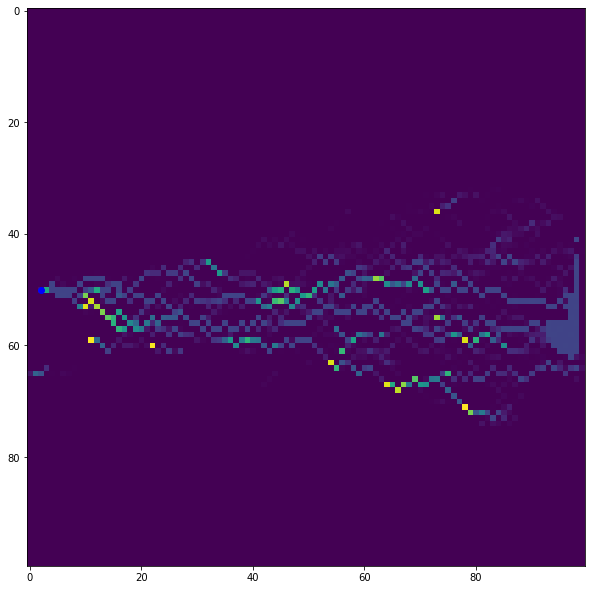

Fitness: 0.0458456964158859
Time to simulate 1 N in 147.7574 seconds


<Figure size 720x1440 with 0 Axes>

In [15]:
q = 35
sigma_1 = 55
sigma_2 = 250
mu = 3.7
delta = 0.06679
   
# q = 3.66812893e+01
# sigma_1 = 5.83832896e+02
# sigma_2 = 6.34628836e+01
# mu = 3.61564074e+01
# delta = 9.75544849e-02

Am = 30
Nb = 10

m = 2
n = 50

T = 200
F = 4

g = Grid(100, 100, m, n, delta, T, F)
ants = list()

tic = time.perf_counter()
fitness = simulate(g, ants, q, sigma_1, sigma_2, mu, delta, Am, Nb, iterations=500)
toc = time.perf_counter()
print("Fitness:", fitness)
print(f"Time to simulate 1 N in {toc - tic:0.4f} seconds")